## Modules

In [1]:
#################################
#          Modules              #
#################################

import ee
from datetime import datetime
from IPython.display import Image, display,HTML
from ee_ipl_uv import multitemporal_cloud_masking
from ee_ipl_uv import download
import os
import requests

ee.Initialize()

## Data

In [2]:
#################################
#            DATA               #
#################################

# Image & dataset name 
image_index = "LC08_204020_20180704"          # Image to remove clouds
dataset_index = 'LANDSAT/LC08/C01/T1_TOA'     # Dataset containing picture

# Import Image from Google Earth Data
image_predict_clouds = ee.Image(dataset_index + '/' + image_index)  

# Area analyzed
region_of_interest = ee.Geometry.Polygon(
    [[[-2.775208282272615,57.01860739003285],
        [-2.453858184616365,57.01860739003285],
        [-2.453858184616365,57.18122162676308],
        [-2.775208282272615,57.18122162676308]]])

# Date of image analyzed
datetime_image = datetime.utcfromtimestamp(image_predict_clouds.get("system:time_start").getInfo()/1000).strftime("%Y-%m-%d %H:%M:%S")

## Visualization image with cloud

In [3]:
#################################
#     Visualization Image       #
#################################
imageRGB = image_predict_clouds.visualize(max=.3,bands=["B4","B3","B2"])
image_file_original = download.MaybeDownloadThumb(imageRGB.clip(region_of_interest),params={"dimensions": "400x400"})

def viz_cloudscore_mask(cloudscoremask):
    cloudscoremask_vis = cloudscoremask.updateMask(cloudscoremask)
    cloudscoremask_vis = cloudscoremask_vis.visualize(max=1,min=0,palette=['1f77b4', 'ff7f0e'])
    mosaic = ee.ImageCollection([imageRGB, cloudscoremask_vis]).mosaic()
    return download.MaybeDownloadThumb(mosaic.clip(region_of_interest),params={"dimensions": "400x400"})

## Persistence method 

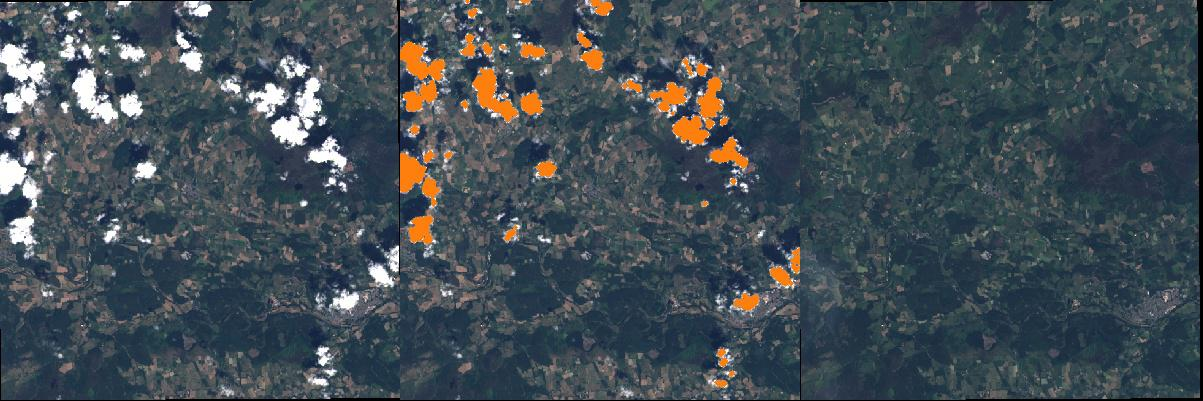

In [4]:
#################################
#     Méthod persistence        #
#################################
cloud_score_persistence, pred_persistence = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,
                                                                                         region_of_interest,
                                                                                         method_pred="persistence")
persistence_pred_file = download.MaybeDownloadThumb(pred_persistence.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_persistence), persistence_pred_file]

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore from persistence method cloud mask</center>"%datetime_image))

## Percentile method

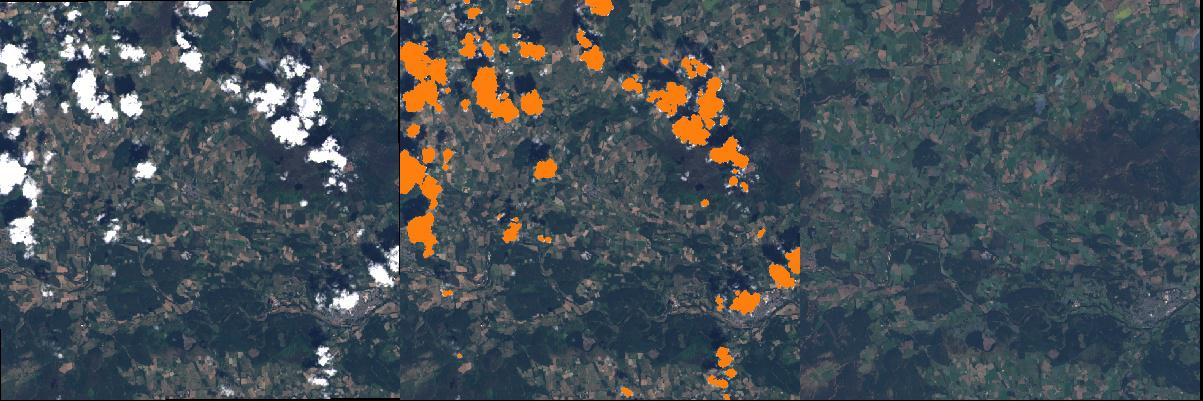

In [5]:
#################################
#     Méthod percentile         #
#################################
cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,region_of_interest,
                                                                                        method_pred="percentile",
                                                                                        num_images=3)
percentile_pred_file = download.MaybeDownloadThumb(pred_percentile.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_percentile), percentile_pred_file]

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
        HTML("<center>Percentile prediction</center>"))

## Percentile method without threshold in reflectance

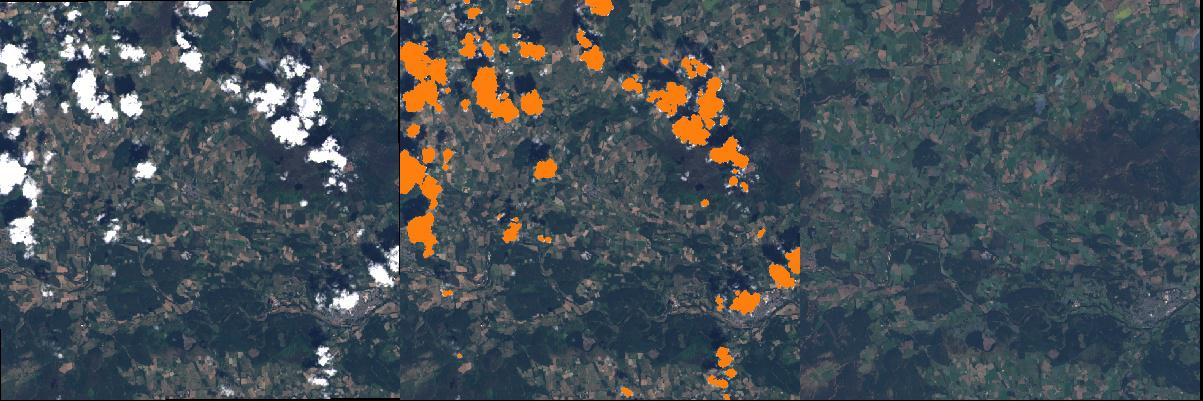

In [6]:
#######################################################
#  Percentile method without threshold in reflectance #
#######################################################

cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,region_of_interest,
                                                                                       method_pred="percentile",
                                                                                       params={"threshold_reflectance":0},
                                                                                       num_images=3)
percentile_pred_file = download.MaybeDownloadThumb(pred_percentile.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})

list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_percentile), percentile_pred_file]

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])
display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of percentile method cloud mask</center>"%datetime_image))

## Percentile method without clustering

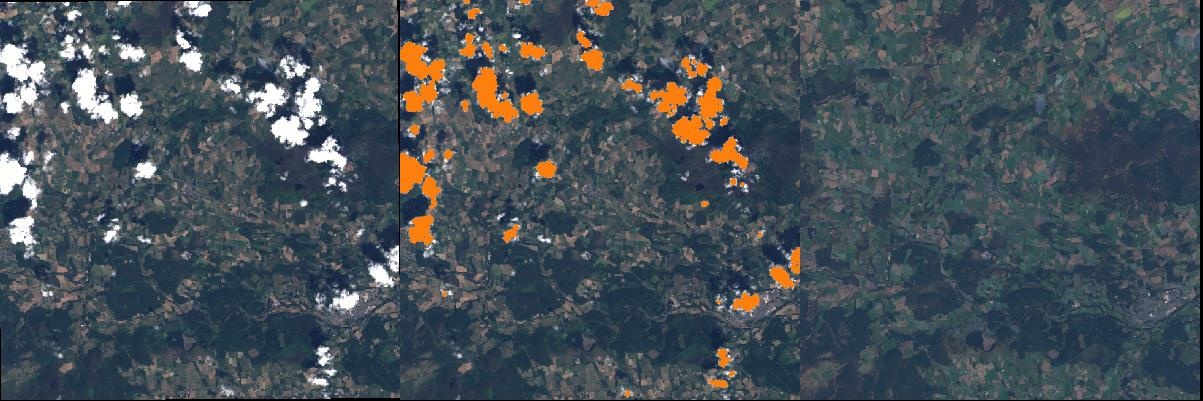

In [7]:
########################################
# Percentile method without clustering #
########################################

cloud_score_percentile,pred_percentile = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,region_of_interest,
                                                                                       method_pred="percentile",
                                                                                       params={"do_clustering":False},
                                                                                       num_images=3)

percentile_pred_file = download.MaybeDownloadThumb(pred_percentile.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})

list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_percentile), percentile_pred_file]

img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of percentile method cloud mask</center>"%datetime_image))

## Linear method 

In [8]:
##################################
#          Linear method         #
##################################

from ee_ipl_uv import download
import logging
import sys
def screen_logger(logger,level=logging.INFO):
    logger.setLevel(level)
    formatter = logging.Formatter(
       '%(asctime)-12s %(name)-12s %(levelname)-8s %(message)s',
       datefmt="%Y-%m-%d %H:%M:%S")
    
    # logger to stdout
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(level)
    handler.setFormatter(formatter)
    logger.addHandler(handler)

screen_logger(download.logger)
screen_logger(multitemporal_cloud_masking.logger)
download.logger.info("Turn on logging")

cloud_score_linear,pred_linear = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,region_of_interest,
                                                                               method_pred="linear",
                                                                               num_images=3)
"""
pred_linear_file = download.MaybeDownloadThumb(pred_linear.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
display(Image(pred_linear_file),
        HTML("<center>Linear method prediction</center>"))

list_images_show = [image_file_original,viz_cloudscore_mask(cloud_score_linear), pred_linear_file]


img_files_composite_per = download.MosaicImageList(list_images_show,
                                                   [1,len(list_images_show)])

display(Image(img_files_composite_per),
       HTML("<center>Landsat 8 TOA image %s with clusterscore of linear method cloud mask</center>"%datetime_image))
"""

2019-04-29 16:10:36 ee_ipl_uv.download INFO     Turn on logging
2019-04-29 16:10:51 ee_ipl_uv.download INFO     Elapsed: 0s Status: READY
2019-04-29 16:11:57 ee_ipl_uv.download INFO     Elapsed: 60s Status: RUNNING
2019-04-29 16:12:41 ee_ipl_uv.download INFO     ee.task COMPLETED 100s. Starting download from Google Drive


C:\Users\AB43536\AppData\Local\Continuum\anaconda3\lib\site-packages\oauth2client\_helpers.py:255: UserWarning: Cannot access mycreds.txt: No such file or directory
  warnings.warn(_MISSING_FILE_MESSAGE.format(filename))


InvalidConfigError: Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)

## Kernel method

In [ ]:
############################
#       Kernel method      #
############################

cloud_score_kernel,pred_kernel = multitemporal_cloud_masking.CloudClusterScore(image_predict_clouds,
                                                                               region_of_interest,
                                                                               method_pred="kernel",num_images=3,
                                                                               params={"sampling_factor":0.00005,
                                                                                       "lmbda": 0.001,
                                                                                       "do_clustering":False,
                                                                                        "gamma": 0.011})

pred_kernel_file = download.MaybeDownloadThumb(pred_kernel.clip(region_of_interest),
                                                   params={"dimensions": "400x400",
                                                           "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                           "max":.3})
display(Image(pred_kernel_file),
        HTML("<center>Kernel method prediction</center>"))